In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pickle
%matplotlib inline

In [2]:
nx = 9
ny = 6
objpoints = []
imgpoints = []
shape = []
parent = Path(os.getcwd()).parent    
folder = 'camera_cal'
for filename in os.listdir(folder):
    if filename.endswith(".jpg"):        
        image_path = folder+ '\\' +filename 
        #print(image_path)
        img = cv2.imread(image_path)
        shape = img.shape
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
        objp = np.zeros((ny*nx,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 
            
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        # If found, make note of corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape[1::-1], None, None)
img = cv2.imread(folder+'\\'+'calibration1.jpg')
 
undist = cv2.undistort(img, mtx, dist, None, mtx)

print('saving to pickle...')
pickle_data = {"mtx" : mtx, "dist" : dist}
print(mtx)
print(dist)
pickle.dump( pickle_data, open( "data.p", "wb" ) )
print('saved!')



saving to pickle...
[[1.15777818e+03 0.00000000e+00 6.67113857e+02]
 [0.00000000e+00 1.15282217e+03 3.86124583e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.24688507 -0.02373156 -0.00109831  0.00035107 -0.00259866]]
saved!


(<matplotlib.image.AxesImage at 0x2071878b438>,
 <matplotlib.text.Text at 0x20718777b38>)

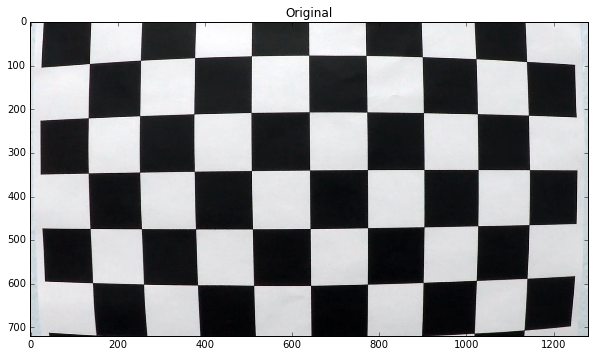

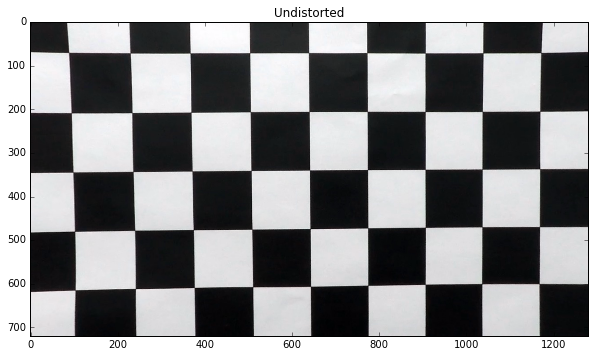

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(img),plt.title('Original')

plt.figure(figsize=(10,10))
plt.imshow(undist),plt.title('Undistorted')


In [4]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20,100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

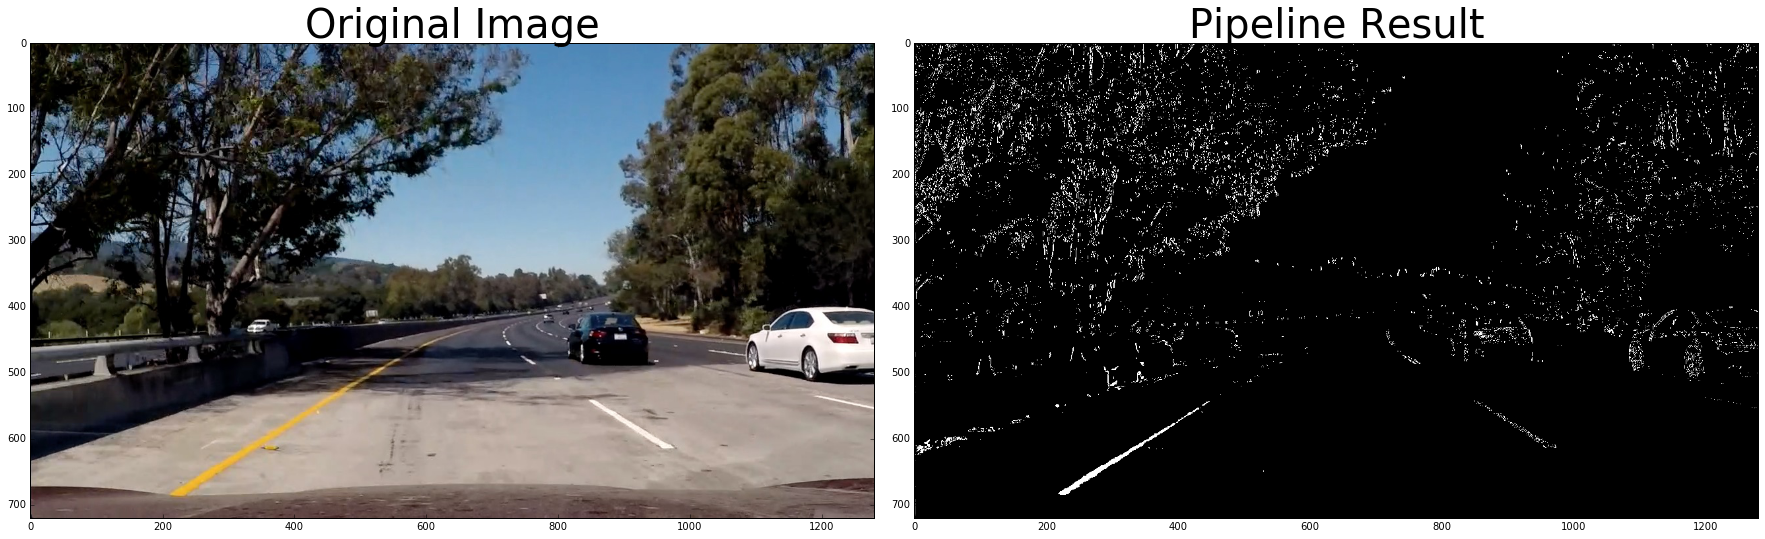

In [5]:
folder = str(Path(os.getcwd())) + '\\test_images'
img_path = folder + '\\test5.jpg'

img_bgr = cv2.imread(img_path)
image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

colored_result, result = pipeline(image, (200,250), (60,100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


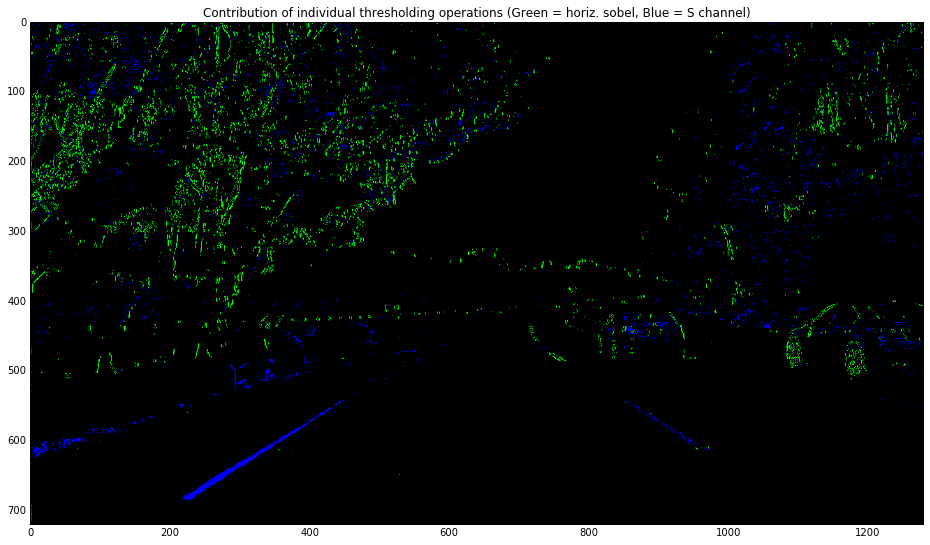

In [6]:
plt.figure(figsize=(24,9))
plt.title('Contribution of individual thresholding operations (Green = horiz. sobel, Blue = S channel)')
plt.imshow(colored_result)


In [7]:
def draw_lines(image, pts):    
    if(len(image.shape)<3):
        image_lined = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_lined = np.copy(image)
    thickness = 3
    cv2.line(image_lined, tuple(pts[0]), tuple(pts[1]), (255,0,0), thickness)
    cv2.line(image_lined, tuple(pts[1]), tuple(pts[2]), (255,0,0), thickness)
    cv2.line(image_lined, tuple(pts[2]), tuple(pts[3]), (255,0,0), thickness)
    cv2.line(image_lined,tuple(pts[3]), tuple(pts[0]), (255,0,0), thickness)
    if(len(image.shape)<3):
        img_stack = np.dstack((image, image, image)) * 255
        result = cv2.addWeighted(img_stack, 0.8, image_lined, 1, 0)         
    else:
        result = np.copy(image_lined)
    return result

In [8]:
src = np.float32([[543,480],[307,645], [1003,645],[730,480]])
dst = np.float32([[300,0],[300,700],[900,700],[900,0]])

In [9]:
pickle_data = pickle.load( open( "data.p", "rb" ) )
dist = pickle_data['dist']
mtx = pickle_data['mtx']

In [10]:
def perspective_transformation(image, mtx, dist, src, dst, should_display_figures = True):
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)

    image_annotated = draw_lines(image, src)
    undist_annotated = draw_lines(undist, src)
    warped_annotated = draw_lines(warped, dst) 
    
    if not should_display_figures:
        return warped, M_inv

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    if(len(undist_annotated.shape)<3):
        ax1.imshow(undist_annotated, cmap='gray')
    else:
        ax1.imshow(undist_annotated)
    ax1.set_title('Undistorted image with source points', fontsize=20)

    if(len(warped_annotated.shape)<3):
        ax2.imshow(warped_annotated, cmap='gray')
    else:
        ax2.imshow(warped_annotated)
    ax2.set_title('Warped image with destination points', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return warped, M_inv


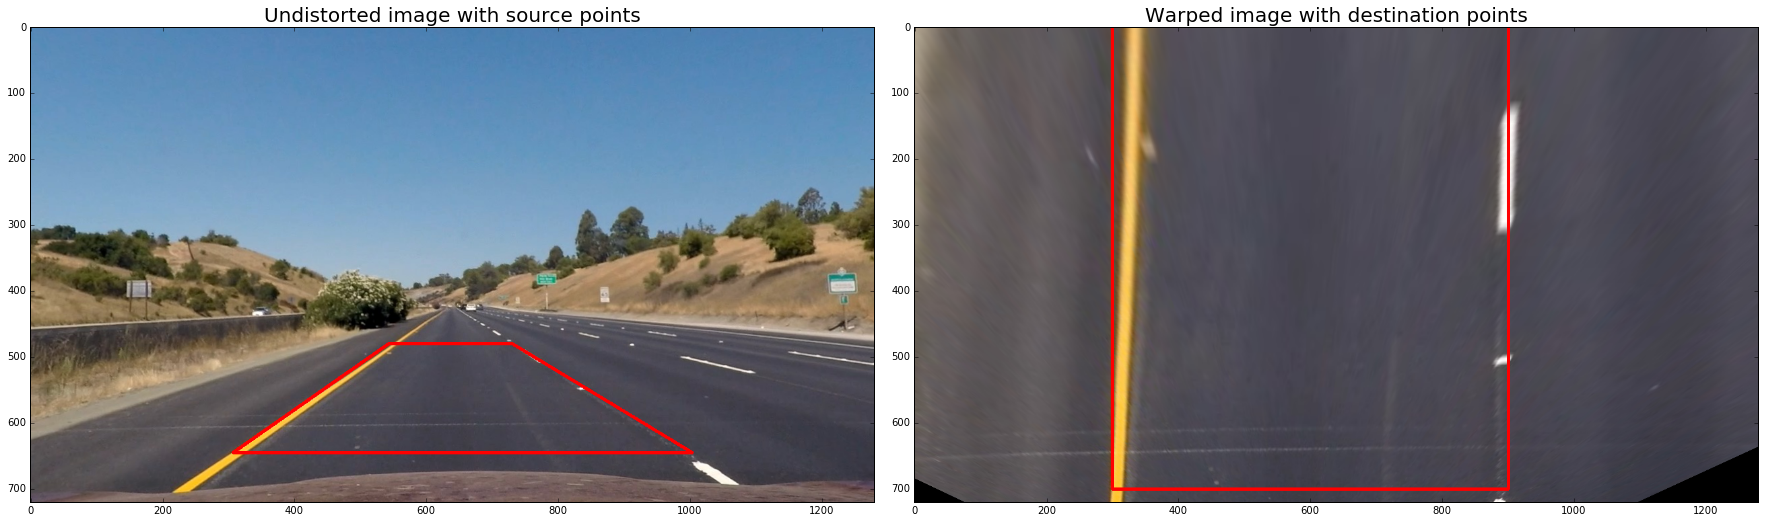

In [11]:
folder = str(Path(os.getcwd())) + '\\test_images'
img_path = folder + '\\straight_lines1.jpg'
img_bgr = cv2.imread(img_path)
image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
warped_straight_lines, m_inv = perspective_transformation(image, mtx, dist, src, dst, True)

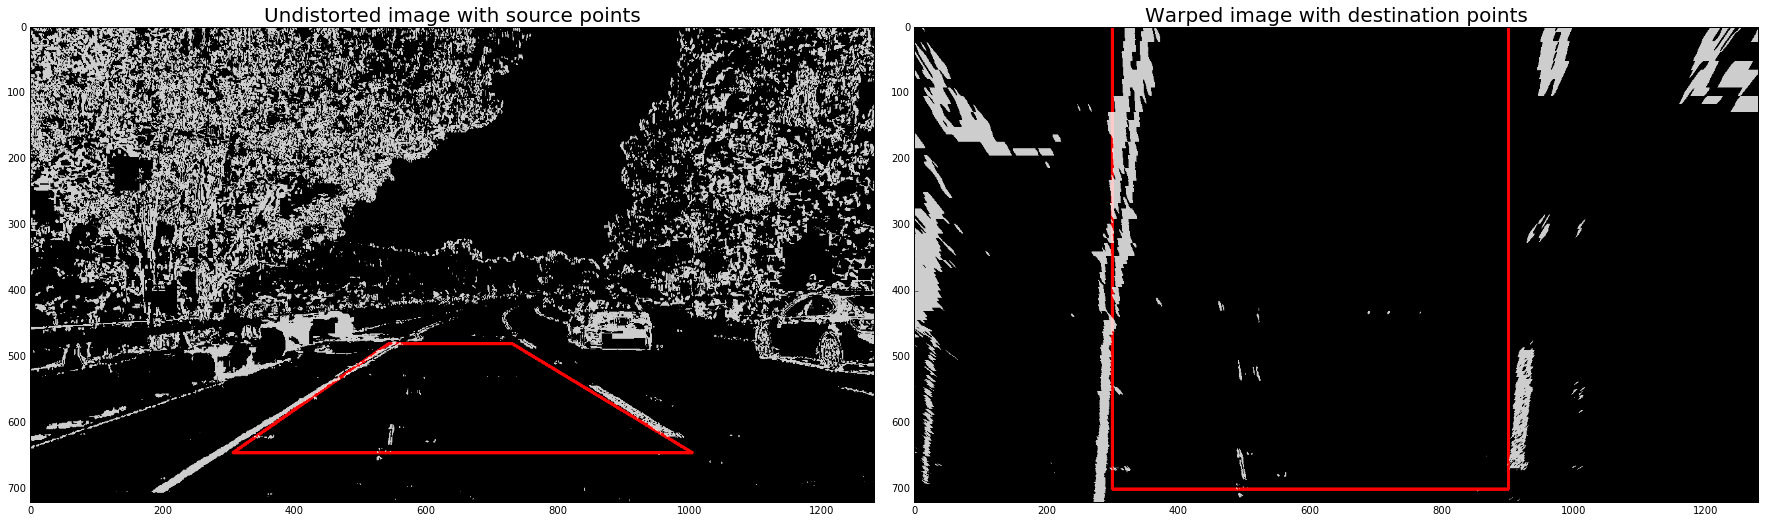

In [12]:
img_path = folder + '\\test5.jpg'
img_bgr = cv2.imread(img_path)
image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
colored_result, image_pipeline = pipeline(image)
warped_test_image, m_inv2 = perspective_transformation(image_pipeline, mtx, dist, src, dst)

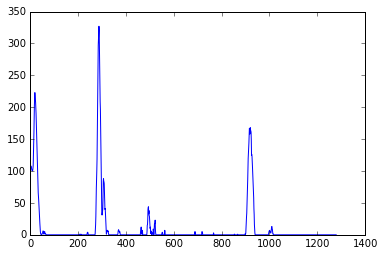

In [13]:
histogram = np.sum(warped_test_image[warped_test_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [14]:
def find_lines(warped_image):
    
    binary_warped = np.copy(warped_image)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, leftx, lefty, rightx, righty, left_fit, right_fit

In [15]:
out_img, leftx, lefty, rightx, righty, left_fit, right_fit = find_lines(warped_test_image)

(720, 0)

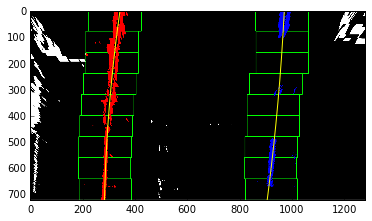

In [16]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped_test_image.shape[0]-1, warped_test_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Metrics

In [17]:
def get_curvature_pixel_space(left_fit, right_fit, ploty):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad 

In [18]:
ploty = np.linspace(0, warped_test_image.shape[0]-1, warped_test_image.shape[0] )
left_curverad, right_curverad = get_curvature_pixel_space(left_fit, right_fit, ploty)
print('left_curvature = ', left_curverad, ', right_curvature = ', right_curverad)

left_curvature =  6022.287111201911 , right_curvature =  9189.403515358728


In [19]:
def get_radius_of_curvature(leftx, lefty, rightx, righty, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius_of_curvature = 0.5 * (left_curverad + right_curverad)
    return radius_of_curvature
    

In [20]:
ploty = np.linspace(0, warped_test_image.shape[0]-1, warped_test_image.shape[0] )
radius_of_curvature = get_radius_of_curvature(leftx, lefty, rightx, righty, ploty) 
print('radius of curvature = ', radius_of_curvature, 'm')

radius of curvature =  2460.282293536861 m


In [21]:
def get_offset(left_fit, right_fit, image_shape):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    x_left = left_fit[0]*(image_shape[0]**2) + left_fit[1]*image_shape[0] + left_fit[2]
    x_right = right_fit[0]*(image_shape[0]**2) + right_fit[1]*image_shape[0] + right_fit[2]
    lane_center = (x_left + x_right)/2
    offset = (image_shape[1]/2 - lane_center) * xm_per_pix
    return offset

In [22]:
offset = get_offset(left_fit, right_fit, image.shape)
print('offset = ', offset, 'm')

offset =  0.2397221081145281 m


# Annotate the original image

In [23]:
def warp_and_draw_lanes(image, m_inv, left_fit, right_fit):
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lanes_only_image = np.zeros((image.shape[0], image.shape[1], 3), dtype='uint8')
    
    left_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((left_points, right_points))    
        
    cv2.fillPoly(lanes_only_image, np.int_([points]), (0,255, 0))   
        
    cv2.fillPoly(lanes_only_image, np.int_([left_points]), (0,0, 255))  
    cv2.fillPoly(lanes_only_image, np.int_([right_points]), (255,0, 0))  
    warped_lanes_only_image = cv2.warpPerspective(lanes_only_image, m_inv, (image.shape[1], image.shape[0]))    
    res = cv2.addWeighted(image, 1, warped_lanes_only_image, 0.4, 0)
    return res

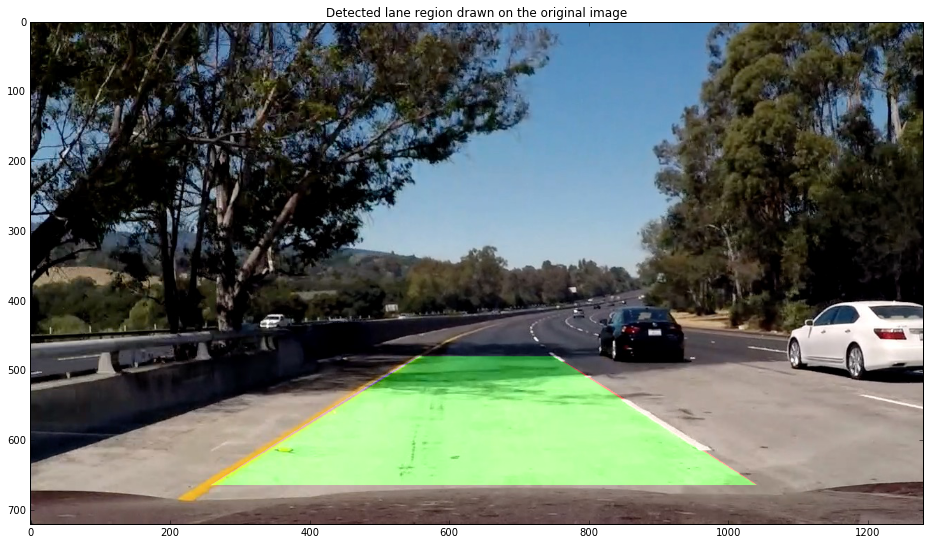

In [24]:
m_inv = cv2.getPerspectiveTransform(dst, src)
original_image = np.copy(image)
lanes_on_original_image = warp_and_draw_lanes(original_image, m_inv, left_fit, right_fit)

plt.figure(figsize=(24, 9))
plt.title('Detected lane region drawn on the original image')
plt.imshow(lanes_on_original_image)

In [25]:
def annotate_image(image, radius_of_curvature, offset_from_center):
    image_text_size = 1.5
    text_annotated_original_image = np.copy(image)
    #display radius of curvature
    text_radius_of_curvature = 'Radius of curvature = %.3f m' % radius_of_curvature
    text_annotated_original_image = cv2.putText(text_annotated_original_image, text_radius_of_curvature, (40,50), 0, image_text_size, (255,255,255), 2, cv2.LINE_AA)

    #display offset from center    
    text_offset = 'Vehicle offset from center = %.3f m' % offset_from_center
    text_annotated_original_image = cv2.putText(text_annotated_original_image, text_offset, (40,105), 0, image_text_size, (255,255,255), 2, cv2.LINE_AA)
    return text_annotated_original_image


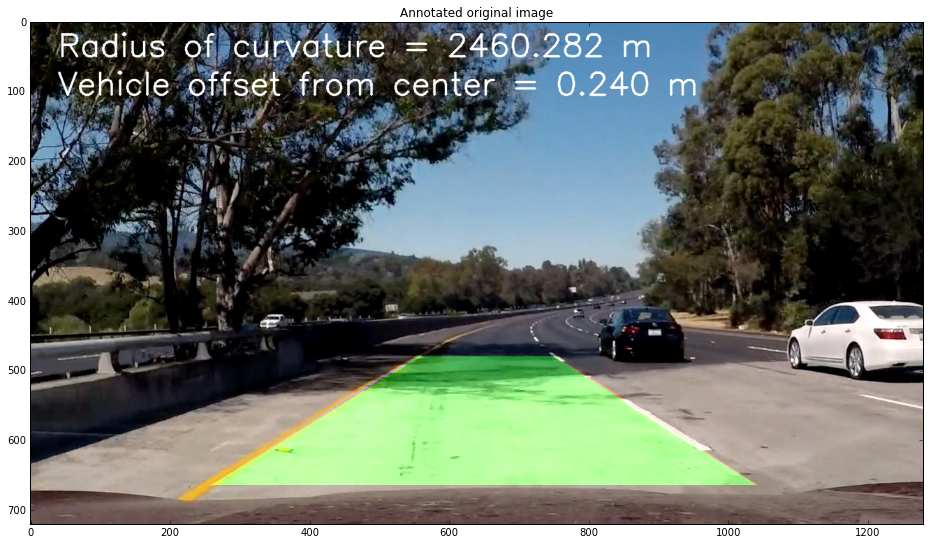

In [26]:
text_annotated_original_image = annotate_image(lanes_on_original_image, radius_of_curvature, offset)
plt.figure(figsize=(24, 9))
plt.title('Annotated original image')
plt.imshow(text_annotated_original_image)

# Video

In [27]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [28]:
def find_lines_optimized(image, left_fit, right_fit):
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return leftx, lefty, rightx, righty, left_fit, right_fit

In [32]:
pickle_data = pickle.load( open( "data.p", "rb" ) )
dist = pickle_data['dist']
mtx = pickle_data['mtx']
src = np.float32([[543,480],[307,645], [1003,645],[730,480]])
dst = np.float32([[300,0],[300,700],[900,700],[900,0]])
left_fit_recent = []
right_fit_recent = []
smooth_window_size = 5
smooth_threshold = 100
def process_image(image):    
    
    try:
        
        global dist, mtx, src, dst, left_fit_recent, right_fit_recent
        
        original_image = np.copy(image)
        colored_result, pipeline_output_image = pipeline(original_image, (200,250), (60,100))    
        warped_image, M_inv = perspective_transformation(pipeline_output_image, mtx, dist, src, dst, False)
        out_img, leftx, lefty, rightx, righty, left_fit, right_fit = find_lines(warped_image)
            
        ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
        radius_of_curvature = get_radius_of_curvature(leftx, lefty, rightx, righty, ploty)
        offset = get_offset(left_fit, right_fit, warped_image.shape)
        
        lanes_on_original_image = warp_and_draw_lanes(original_image, M_inv, left_fit, right_fit)
        text_annotated_original_image = annotate_image(lanes_on_original_image, radius_of_curvature, offset)
        return text_annotated_original_image    
    except: 
    
        return image

In [33]:
project_video_path = 'project_video.mp4'
output_video_path = 'project_video_output.mp4'
video = VideoFileClip(project_video_path)
output_video = video.fl_image(process_image)
%time output_video.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:50<00:00,  7.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 51s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))